In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from numba import njit

In [50]:

# ------------------------------------------------------------------------------
# Parameters & Constants for Phase-Field Model
# ------------------------------------------------------------------------------

M = 1.0 #mobility constant, m^5/(J*s)
kappa = 4.0 #gradient energy constant, J/m
xmax = 50.0 #physical domain size, m
nx = 300 #number of spatial discretization points
dx = xmax/(nx-1) #spatial discretization step, m
x = np.linspace(-xmax/2, xmax/2, nx) #spatial grid
dt = 0.1 #0.0271 #time step, s
nsteps = 200000 #number of time steps
trans = 0 #number of transition steps between two phases

#intialize the composition field

comp = np.zeros(nx) #composition field

comp[0:int(nx/2 - trans/2)] = 0.0 #left phase

comp[int(nx/2 + trans/2):nx] = 1.0 #right phase

for i in range (trans):
    comp[int(nx/2 - trans/2 + i)] = 1.0/trans * i #linear transition


Time step 9000/90000 completed
Time step 18000/90000 completed
Time step 27000/90000 completed
Time step 36000/90000 completed
Time step 45000/90000 completed
Time step 54000/90000 completed
Time step 63000/90000 completed
Time step 72000/90000 completed
Time step 81000/90000 completed


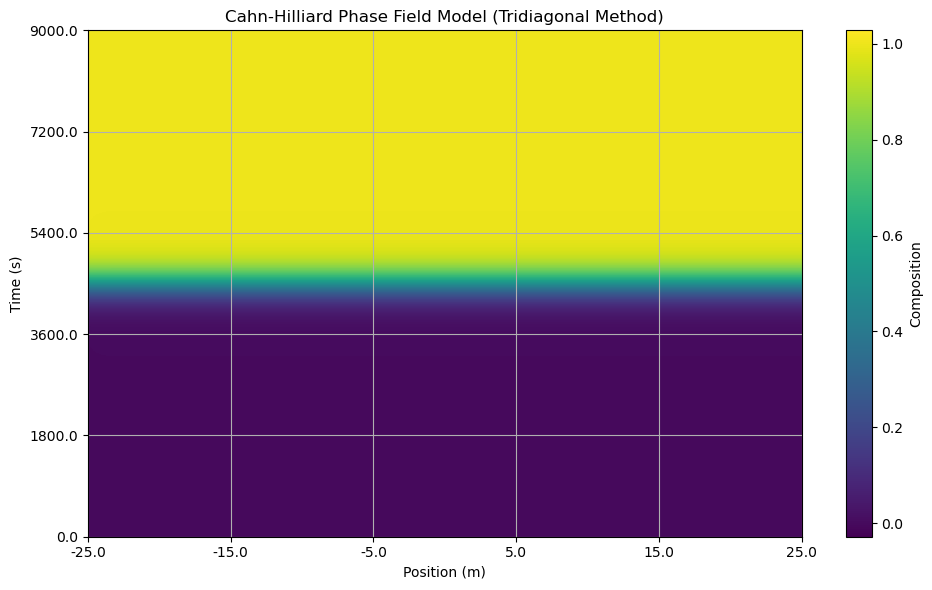

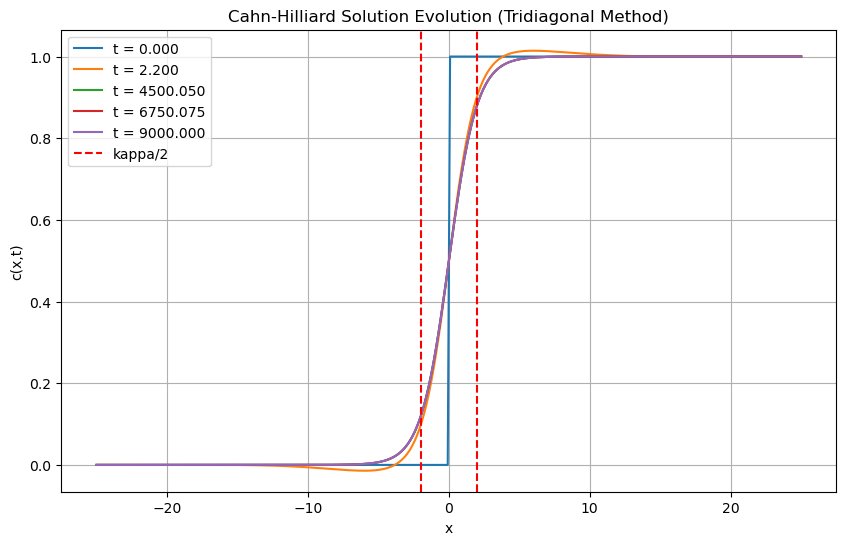

In [51]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def CrankNicolson(n, T=1.0, L=50.0, M=1.0, kappa=4.0):
    """
    Improved Crank-Nicolson implementation for Cahn-Hilliard equation
    with more implicit treatment of the nonlinear term
    """
    N = n**2  # Time steps
    
    # Spatial domain
    x0, xL = -L/2, L/2
    dx = (xL - x0)/(n-1)
    
    # Time domain
    dt = 0.1
    t0, tF = 0, dt*N
    
    # Grid
    xspan = np.linspace(x0, xL, n)
    tspan = np.linspace(t0, tF, N)
    
    # Laplacian operator matrix with Neumann BCs
    lambda_lap = 1.0 / dx**2
    maindiag = -2 * lambda_lap * np.ones(n)
    offdiag = lambda_lap * np.ones(n-1)
    
    # Create sparse laplacian matrix
    laplacian = sparse.diags([offdiag, maindiag, offdiag], [-1, 0, 1], 
                           shape=(n, n), format='csr')
    
    # Apply Neumann boundary conditions
    laplacian[0, 0] = -lambda_lap
    laplacian[0, 1] = lambda_lap
    laplacian[n-1, n-1] = -lambda_lap
    laplacian[n-1, n-2] = lambda_lap
    
    def df_dC(C):
        """Derivative of free energy density f'(C) = 4C(1-C)(1-2C)"""
        return 4 * C * (1 - C) * (1 - 2 * C)
    
    def d2f_dC2(C):
        """Second derivative of free energy density f''(C)"""
        return 4 * (1 - 6*C + 6*C**2)
    
    # Initialize solution matrix
    U = np.zeros((n, N))
    
    # Initial condition (same as your original)
    comp = np.zeros(n)
    comp[0:int(n/2)] = 0.0
    comp[int(n/2):n] = 1.0
    U[:, 0] = comp
    
    # Time stepping
    for k in range(1, N):
        u_old = U[:, k-1]
        u_new = u_old.copy()  # Initial guess
        
        # Newton iteration for implicit treatment
        for newton_iter in range(10):  # Max Newton iterations
            # Current derivatives
            df_curr = df_dC(u_new)
            d2f_curr = d2f_dC2(u_new)
            
            # Chemical potential and its Jacobian
            lap_u = laplacian @ u_new
            mu = df_curr - kappa * lap_u
            
            # Residual: (u_new - u_old)/dt - M * nabla^2(mu) = 0
            residual = (u_new - u_old)/dt - M * (laplacian @ mu)
            
            # Jacobian terms
            # d(mu)/du = d2f_dC2 - kappa * laplacian
            dmu_du = sparse.diags(d2f_curr) - kappa * laplacian
            
            # Full Jacobian: I/dt - M * laplacian * dmu_du
            jacobian = sparse.eye(n)/dt - M * laplacian @ dmu_du
            
            # Newton update
            try:
                delta_u = spsolve(jacobian, residual)
                u_new = u_new - delta_u
                
                # Check convergence
                if np.linalg.norm(delta_u) < 1e-10:
                    break
            except:
                print(f"Linear solve failed at time step {k}")
                break
        
        U[:, k] = u_new
        
        # Optional: print progress
        if k % (N//10) == 0:
            print(f"Time step {k}/{N} completed")
    
    return U, tspan, xspan


U, tspan, xspan = CrankNicolson(nx)

plt.figure(figsize=(10, 6))
plt.imshow(U, aspect='auto', extent=[0, xmax, 0, 1], origin='lower', cmap='viridis')
plt.colorbar(label='Composition')
plt.title('Cahn-Hilliard Phase Field Model (Tridiagonal Method)')
plt.xlabel('Position (m)')
plt.ylabel('Time (s)')
plt.xticks(np.linspace(0, xmax, 6), np.round(np.linspace(-xmax/2, xmax/2, 6), 1))
plt.yticks(np.linspace(0, 1, 6), np.round(np.linspace(0, tspan[-1], 6), 2))
plt.grid()
plt.tight_layout()
plt.show()

# Plot solution at different times
plt.figure(figsize=(10, 6))
for j in [0, nx**2//4000, nx**2//2, 3*nx**2//4, nx**2-1]:  # Plot at 5 different times
    plt.plot(xspan, U[:,j], label=f't = {tspan[j]:.3f}')
plt.axvline(kappa/2, color='r', linestyle='--', label='kappa/2')
plt.axvline(-kappa/2, color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('c(x,t)')
plt.legend()
plt.title('Cahn-Hilliard Solution Evolution (Tridiagonal Method)')
plt.grid(True)
plt.show()